# Retail ML Project
Problem statement:
- It is a business critical requirement to understand the value derived from a customer. RFM is a method used for analyzing customer value.
- Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value). 
- Identifying the most valuable RFM segments can capitalize on chance relationships in the data used for this analysis.


Objectives:
- Data Cleaning
- Data Transformation
- Data Modeling


Data Description:
- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
-Quantity: The quantities of each product (item) per transaction. Numeric. 
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated. 
- UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal, the name of the country where each customer resides.


## Data Cleaning
- Insepect the data and understand it 
- Clean the data to improve quality

### Inspecting the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pip install openpyxl
import openpyxl

In [2]:
# Step 0 - Open the excel file and read the descriptions
# Load the dataset and check it 
df = pd.read_excel("./datasets/train.xlsx")
df

In [ ]:
# 379336 rows and 8 columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379336 entries, 0 to 379335
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    379336 non-null  object        
 1   StockCode    379336 non-null  object        
 2   Description  378373 non-null  object        
 3   Quantity     379336 non-null  int64         
 4   InvoiceDate  379336 non-null  datetime64[ns]
 5   UnitPrice    379336 non-null  float64       
 6   CustomerID   285076 non-null  float64       
 7   Country      379336 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 23.2+ MB


### Cleaning the data
- Drop duplicates
- Check for NaN
- Format the data
- Check for unreasonable values

In [ ]:
# Drop duplicates
df = df.drop_duplicates()

In [ ]:
# df.isnull().sum() # Also works since there are little columns
# First find the column names that have missing data
empty_cols = df.columns[df.isna().any()].tolist()

# Add the number of missing data next to the column name
for x, i in enumerate(empty_cols):
    if i in df.columns:
        empty_cols[x] = empty_cols[x] + f" {df[i].isnull().sum()}"
print(empty_cols)


['Description 963', 'CustomerID 94243']


NLP will not be used in this model. Hence, the description column can be safely dropped.

On the other hand, missing customer id cannot be averaged and must have the row dropped.

In [ ]:
df = df.dropna()
df = df.drop(["Description"], axis=1)
df.shape

(282420, 7)

In [ ]:
# Convert CustomerID to a string
df["CustomerID"] = df["CustomerID"].astype(int).astype(str)

In [ ]:
df

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,556072,20970,8,2011-06-08 14:57:00,3.75,16126,United Kingdom
2,551739,21559,2,2011-05-04 10:58:00,2.55,18118,United Kingdom
3,541658,21988,1,2011-01-20 12:16:00,0.85,15529,United Kingdom
4,538364,85099C,10,2010-12-10 17:26:00,1.95,14448,United Kingdom
5,552306,84789,4,2011-05-08 15:20:00,3.75,13911,United Kingdom
...,...,...,...,...,...,...,...
379330,553872,21937,5,2011-05-19 14:35:00,2.95,13050,United Kingdom
379331,C554864,22962,-4,2011-05-27 10:36:00,0.85,15122,United Kingdom
379333,572302,22091,1,2011-10-23 14:47:00,0.39,15427,United Kingdom
379334,559339,84946,60,2011-07-07 16:49:00,1.25,13752,United Kingdom


In [ ]:
# Check if the numeric columns have any sketchy numbers
for col in df.columns:
    if df[col].dtype in ["int64", "float64", "int32", "int16", "float32"]:
        if (df[col] < 0).any():
            print(f"Column {col} has negative numbers")
        elif (df[col] == 0).any():
            print(f"Column {col} has 0s")

Column Quantity has negative numbers
Column UnitPrice has 0s


In [ ]:
# Unit price cannot be 0, and discounts usually avoid such exploits.
len(df[df["UnitPrice"]==0]), len(df[df["Quantity"]<0])

(31, 6199)

In [ ]:
df = df[df["Quantity"] >= 0]
df = df[df["UnitPrice"] > 0]
df.shape

(276190, 7)

## Data Transformation
- Create monthly cohorts to analyze active customers
- Analyze the retention rate of customers

In [ ]:
# Add a new column that indicates the month only
# Add another column for the date without the time
df["month_year"] = df.InvoiceDate.dt.to_period("M")
df["purchase_date"] = df["InvoiceDate"].dt.to_period("D")
df["month_year"].unique()

<PeriodArray>
['2011-06', '2011-05', '2011-01', '2010-12', '2011-09', '2011-10', '2011-02',
 '2011-11', '2011-07', '2011-08', '2011-03', '2011-04', '2011-12']
Length: 13, dtype: period[M]

In [ ]:
# Find the monthly unique active users
monthly_customers = df.groupby("month_year")["CustomerID"].nunique()
monthly_customers

month_year
2010-12     872
2011-01     735
2011-02     745
2011-03     964
2011-04     849
2011-05    1043
2011-06     982
2011-07     937
2011-08     923
2011-09    1250
2011-10    1354
2011-11    1654
2011-12     607
Freq: M, Name: CustomerID, dtype: int64

Text(0.5, 0, 'Number of unique active users')

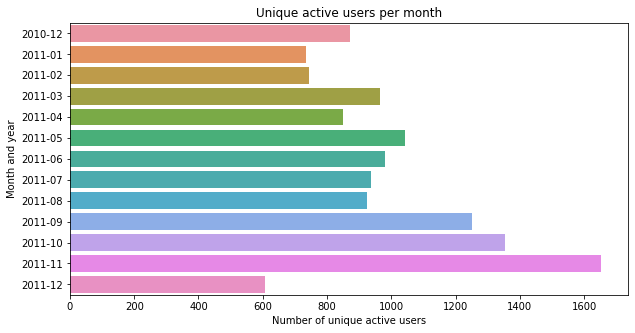

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(y=monthly_customers.index, x=monthly_customers.values)
plt.title("Unique active users per month")
plt.ylabel("Month and year")
plt.xlabel("Number of unique active users")

In [ ]:
# Find the % change from the previous row
retention_rate = round(monthly_customers.pct_change(1)*100,2)

<AxesSubplot:ylabel='month_year'>

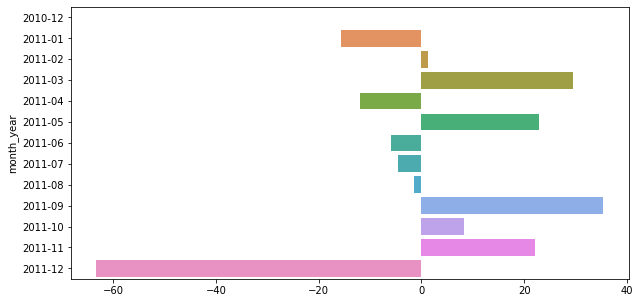

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=retention_rate.values, y= retention_rate.index)

It is clear that the retention rate of the company is poor. 

The retention rate may also be seasonal considering how the highest spikes in customer retention occurs during the months closer to thanksgiving and christmas.

## Data Modeling
- Build an RFM model
- Calculate RFM metrics
- Build RFM segments

### Building an RFM model

In [ ]:
# The latest data has dates up to 2011-12-09
# The reference date will be the day after 2011-12-10
df["purchase_date"].max()

Period('2011-12-09', 'D')

In [ ]:
# Note that the purchase date was previously stored as a period object
# It is converted to a timestamp in the new data frame for conviencence
reference_date = pd.to_datetime("2011-12-10")
df_recency = df.groupby("CustomerID", as_index=False)["purchase_date"].max()
df_recency = df_recency.rename(columns={"CustomerID":"Customer ID"})
df_recency.index = df_recency.index + 1
df_recency["Recency"] = df_recency["purchase_date"].apply(lambda row: (reference_date - row.to_timestamp()).days)
df_recency.drop("purchase_date", axis=1, inplace=True)
df_recency

,Customer ID,Recency
1,12346,326
2,12347,3
3,12348,76
4,12349,19
5,12350,311
...,...,...
4316,18280,278
4317,18281,181
4318,18282,8
4319,18283,4


In [ ]:
# The frequency will be over the whole data set, since it spans 1 year only
# Group the data according to customer ID then count the number of Inovoices
df_frequency = df.groupby("CustomerID", as_index=False)["InvoiceNo"].count()
df_frequency.index = df_frequency.index + 1
df_frequency.rename(columns={"CustomerID":"Customer ID", "InvoiceNo":"Frequency"}, inplace=True)
df_frequency

,Customer ID,Frequency
1,12346,1
2,12347,132
3,12348,20
4,12349,50
5,12350,11
...,...,...
4316,18280,5
4317,18281,5
4318,18282,8
4319,18283,511


In [ ]:
# Calculate the money spent by the customer over the period selected
# In this case over 1 year (13 months in reality)
df["total_sale"] = df.UnitPrice * df.Quantity
df_monetary = df.groupby("CustomerID", as_index=False)["total_sale"].sum()
df_monetary.index = df_monetary.index + 1
df_monetary.rename(columns={"CustomerID":"Customer ID", "total_sale":"Monetary"}, inplace=True)
df_monetary

,Customer ID,Monetary
1,12346,77183.60
2,12347,3124.96
3,12348,1009.88
4,12349,1344.17
5,12350,213.30
...,...,...
4316,18280,91.70
4317,18281,59.28
4318,18282,119.61
4319,18283,1450.29


In [ ]:
# Final RFM Table
rfm_df = df_recency.merge(df_frequency, on='Customer ID')
rfm_df = rfm_df.merge(df_monetary, on="Customer ID")
rfm_df.index = rfm_df.index + 1
rfm_df

,Customer ID,Recency,Frequency,Monetary
1,12346,326,1,77183.60
2,12347,3,132,3124.96
3,12348,76,20,1009.88
4,12349,19,50,1344.17
5,12350,311,11,213.30
...,...,...,...,...
4316,18280,278,5,91.70
4317,18281,181,5,59.28
4318,18282,8,8,119.61
4319,18283,4,511,1450.29


### Calculating the RFM score

In [ ]:

# The results must now be normalized in order to rank the customer
# Recency is better when lower, hence the lower the score the higher the rank
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['M_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head()

,Customer ID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
1,12346,326,1,77183.60,3.868944,1.122685,99.837963,5.78
2,12347,3,132,3124.96,96.189148,88.576389,92.708333,9.21
3,12348,76,20,1009.88,38.213082,38.935185,71.226852,5.72
4,12349,19,50,1344.17,74.416173,65.949074,78.425926,7.43
5,12350,311,11,213.30,5.356105,23.148148,25.486111,2.18


In [ ]:

# Different weights will be given for each rank
# Recency receives least, while monetary receives the most
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm'] + 0.28* \
    rfm_df['F_rank_norm'] + 0.57*rfm_df['M_rank_norm']

# The RFM score will be out of 10 and consist of 2 decimal places
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['Customer ID', 'RFM_Score']].sort_values(by=["RFM_Score"], ascending=False)

,Customer ID,RFM_Score
1871,14911,4.99
2167,15311,4.99
1681,14646,4.99
327,12748,4.98
3994,17841,4.97
...,...,...
1644,14589,0.07
1634,14576,0.06
1807,14821,0.04
1525,14437,0.03


### RFM Segmentation

Newest        2665
Recent         609
Occasional     418
Seasonal       356
Lost           272
Name: recency_labels, dtype: int64

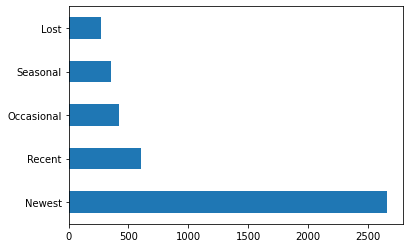

In [ ]:
rfm_segs = pd.DataFrame()
rfm_segs["recency_labels"] = pd.cut(rfm_df["Recency"], bins=5, 
    labels=["Newest", "Recent", "Occasional", "Seasonal", "Lost"])
rfm_segs["recency_labels"].value_counts().plot(kind="barh");
rfm_segs["recency_labels"].value_counts()

Least frequent    4310
Less frequent        6
More frequent        2
Frequent             1
Most frequent        1
Name: frequency_labels, dtype: int64

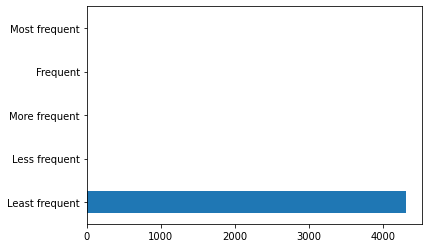

In [ ]:
rfm_segs["frequency_labels"] = pd.cut(rfm_df["Frequency"], bins=5, 
    labels=["Least frequent", "Less frequent", "Frequent", "More frequent", "Most frequent"])
rfm_segs["frequency_labels"].value_counts().plot(kind="barh");
rfm_segs["frequency_labels"].value_counts()

In [ ]:
len(rfm_df[rfm_df["Recency"]>rfm_df["Recency"].max()//5])

1674

# Applying to the test data

In [ ]:
# Apply all the previous steps to the test data
df_test = pd.read_excel("./datasets/test.xlsx")

empty_cols = df_test.columns[df_test.isna().any()].tolist()
# Add the number of missing data next to the column name
for x, i in enumerate(empty_cols):
    if i in df_test.columns:
        empty_cols[x] = empty_cols[x] + f" {df_test[i].isnull().sum()}"
print(empty_cols)

# Drop NaN, description column and fix the customer ID format
df_test = df_test.dropna()
df_test = df_test.drop(["Description"], axis=1)
df_test["CustomerID"] = df_test["CustomerID"].astype(int).astype(str)

df_test = df_test[df_test["Quantity"] >= 0]
df_test = df_test[df_test["UnitPrice"] > 0]

In [ ]:
# Add a new column that indicates the month only
df["month_year"] = df.InvoiceDate.dt.to_period("M")
df["month_year"].unique()